#  MelodyMaster
## Notebook03 - song2vec & Multiclass
### Idan Kashani & Or Raphael Bidusa

# Shalom again!
Today we will examine another representation of the data - song2vec, based on word2vec representation.
We will use this representation with all sorts of different model, hoping to get a better result than last time with our simple knn.

In [34]:
import numpy as np
import pandas as pd
import ast
import warnings
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, confusion_matrix, classification_report
from collections import Counter
import seaborn as sns
import math
import torch
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
np.random.seed(42)

### Loading the dataset and extracting the vocabulary.

In [35]:
train_df = pd.read_csv('./train.csv')
print(f'train shape: {train_df.shape}')
train_df['lyrics_as_list'] = train_df['lyrics'].map(lambda l: set(ast.literal_eval(str(l)))) #Why set?
vocabulary = list(sorted(set.union(*train_df['lyrics_as_list'].tolist())))
train_df['lyrics_as_list'] = train_df['lyrics'].map(lambda l: ast.literal_eval(str(l)))
print(f"Vocabulary length is: {len(vocabulary)}")

train shape: (5255, 6)
Vocabulary length is: 46532


This time we will split the data to train and validation set for in-depth analysis of our results.

In [36]:
from sklearn.model_selection import train_test_split
artists = train_df['artist']
all_but_artists = train_df[['lyrics','lyrics_as_list','song_name','url','words count','unique words count']]

X_train, X_test, y_train, y_test = train_test_split(all_but_artists, artists, test_size=0.2, stratify=artists)
train_df = pd.DataFrame(np.c_[ X_train,y_train], columns = ['lyrics','lyrics_as_list','song_name','url','words count','unique words count','artist'])
val_df = pd.DataFrame(np.c_[ X_test,y_test], columns = ['lyrics','lyrics_as_list','song_name','url','words count','unique words count','artist'])

## Song2Vec
The Song2Vec representation (s2v from now) is based on the [word2vec](https://en.wikipedia.org/wiki/Word2vec) representation for words - a representation that relies on context.
Training a word2vec model in Hebrew is not an easy task - it requires en enormous datasets and a lot of computing power and therefore we shall use an already trained model.
We are using the [Ronshm](https://github.com/Ronshm/hebrew-word2vec) model, based on the entire Hebrew-Wikipedia site.
The tokenization of this model is a bit different - the model separates nouns, adjectives and verbs and marks them with "NN_", "VB_" and "JJ_", we have decided to remove these marks to match our tokenization.

In [37]:
with open('../words_list_w2v.txt',encoding='utf-8') as f:
    words = f.read().split('\n')
    # Removing the last word - an empty word
    words.pop()
vectors = np.load('../words_vectors_w2v.npy')

words = [w[3:] if len(w)>3 and w[:3] in ['NN_','VB_','JJ_'] else w for w in words]

The word `שוטה` for example can be all 3, a noun, a verb and an adjective and therefore has 3 entries.

In [38]:
print(f"The word שוטה has {words.count('שוטה')} entries")
from collections import defaultdict

def list_duplicates(seq):
    tally = defaultdict(list)
    for i,item in enumerate(seq):
        tally[item].append(i)
    return ((key,locs) for key,locs in tally.items()
            if len(locs)>1)

dups_indx = [dup for dup in sorted(list_duplicates(words))]
print(f"There are {len(dups_indx)} types with multiple entries")

The word שוטה has 3 entries
There are 4123 types with multiple entries


We will merge those together, using the mean for the 3 entries.

In [39]:
from collections import OrderedDict

words = list(OrderedDict.fromkeys(words))
vectors_without_dups = vectors.copy()
to_delete = []
for d in dups_indx:
    indices = sorted(d[1])
    vectors_without_dups[indices[0]] = np.mean(vectors[indices])
    to_delete = to_delete + indices[1:]
vectors = np.delete(vectors_without_dups, to_delete, 0)

Now we have a vocabulary of 340,419(!!) words, with corresponding 340,419 vectors.

In [40]:
print(len(words))
print(len(vectors))

340419
340419


Now we will create a way for to jump between the two representations, words and vectors.

In [41]:
w2v = dict(zip(words,vectors))
v2w_rep = dict(zip([tuple(v) for v in vectors],words))
def v2w(vector):
    return v2w_rep[tuple(vector)]

We have a dictionary for word->vector function and a method for the vector->word function.

In [42]:
ahavti_vec = w2v["ישראל"]
print(ahavti_vec)
print(v2w(ahavti_vec))

[ 2.285577 -2.40504  -0.247569  1.565358 -0.507429  0.421352  2.919839
  0.175767 -0.81715   4.027268 -4.426804 -0.335856  1.37266  -2.470423
 -0.637528 -0.625319 -0.387694 -0.377863 -2.823385  0.453176 -0.18862
 -1.135968  1.384955  1.184353 -1.846833 -1.811182  2.862987  0.043025
 -0.208302  0.839443  0.249148 -0.77285  -2.413144  1.783451  2.926803
 -3.261037  0.36823  -3.402674  0.538493 -1.489707 -1.453904 -1.631255
  2.344507 -1.803826 -0.740482  1.634151 -0.077221  0.617151  0.294225
  1.010752 -1.132112  0.357843 -1.024291 -1.490058  0.439202 -3.380302
  1.791306 -3.620549  0.068354 -0.148103 -1.801437  0.181857  3.369811
  4.313795  0.721022  0.792466  2.422217  2.32172   0.197274 -2.948433
  1.928675  0.277213  0.733989 -1.983691  2.088614  1.454925  2.900067
  3.587338  3.282094  0.349965 -2.046078 -1.244647 -0.144329  1.375046
  1.199163 -0.049973  0.327037 -2.425939  0.120854  2.901864  2.422603
 -0.95862   0.298806  1.730013 -1.094935 -0.845992  2.312083 -3.531979
  1.801

## The power of word2vec
With word2vec representation each word is represented by a 100d vector.
In order to demonstrate the meaning of closeness in this vector space we have two methods, one for finding the closest word in the vector space and one for finding the k-closest-vectors.

In [43]:
from scipy.spatial import cKDTree
tree = cKDTree(vectors)

def closest_word(vector):
    return words[tree.query(vector, k=1)[1]]

def k_closest_words(vector, k=5):
    distances, close_words = tree.query(vector, k=k)
    return [(words[w], d) for w, d in zip(list(close_words.astype(int)), distances)]

One interesting result is looking at the closest vectors for the representation of Germany as a vector.
We get a list of countries with both geographic and historical proximity like Austria, Switzerland and even Prussia.

In [44]:
k_closest_words(w2v["גרמניה"],k=10)

[('גרמניה', 0.0),
 ('אוסטריה', 9.436663490929567),
 ('שווייץ', 10.70911817768223),
 ('פרוסיה', 10.974586621357817),
 ('פולין', 11.275983929305372),
 ('הולנד', 11.324757442402465),
 ('צרפת', 11.344306222048795),
 ("צ'כוסלובקיה", 11.5207771481726),
 ('הונגריה', 11.54691985215105),
 ('רוסיה', 11.644340376521805)]

One very interesting test is the analogy test.
Using vector subtraction we can get the "vectorised difference" between two words - the relation between them.
For example, subtracting between "England" and "London" will give us a relation vector of "Capital City".
Adding this "relation vector" to a different word and then finding the closest vector to this sum can sometimes give us the corresponding analogy for this word.
Let's try to add the relation vector of "Capital City" to France, Belgium, Japan or Germany.

In [45]:
# x to y is like a to ?
def analogy(x,y,a):
    return w2v[y]-w2v[x]+w2v[a]

In [46]:
print(closest_word(analogy("אנגליה", "לונדון", "צרפת")))
print(closest_word(analogy("אנגליה", "לונדון", "בלגיה")))
print(closest_word(analogy("אנגליה", "לונדון", "יפן")))
print(closest_word(analogy("אנגליה", "לונדון", "גרמניה")))
print(k_closest_words(analogy("אנגליה", "לונדון", "ישראל")))

פריז
בריסל
טוקיו
ברלין
[('ישראל', 10.9893661164008), ("ישראל'", 16.948512098524905), ('חיפה', 16.98396128039675), ('ירושלים', 17.611764908965654), ('הרצליה', 17.854060380617344)]


The model can also find gendered relations:

In [47]:
print(closest_word(analogy("מלך", "מלכה", "נסיך")))
print(closest_word(analogy("מלך", "מלכה", "מושל")))
print(closest_word(analogy("מלך", "מלכה", "ביישן")))
print(closest_word(analogy("מלך", "מלכה", "מוזיקאי")))
print(k_closest_words(analogy("מלך", "מלכה", "גבר")))

נסיכה
מושלת
ביישנית
מוזיקאית
[("הדג'נס", 14.026844070622879), ('אלייזה', 14.033273028558519), ('ביישנית', 14.119987341728041), ('אשת~חינוך', 14.149295230061124), ('גיבורת~הסיפור', 14.222213031188673)]


For song2vec representation we will try two pooling methods.
Mean-Pooling - taking the mean vector of all the words in the song.
Max-Pooling - for each entry in the 100d vector - taking the max of all words in the song.
For words which do not appear in the dataset - we will ignore them completely.

In [48]:
def song2vec_mean(song):
    return np.mean([w2v[w] for w in song if w in words],axis=0)

def song2vec_max(song):
    return np.max([w2v[w] for w in song if w in words], axis=0)

words_set = set(words)
train_df['song2vec_mean'] = train_df['lyrics_as_list'].map(lambda l: np.mean([w2v[w] for w in l if w in words_set],axis=0))
train_df = train_df.dropna()
train_df['song2vec_max'] = train_df['lyrics_as_list'].map(lambda l: np.max([w2v[w] for w in l if w in words_set],axis=0))

val_df['song2vec_mean'] = val_df['lyrics_as_list'].map(lambda l: np.mean([w2v[w] for w in l if w in words_set],axis=0))
val_df = val_df.dropna()
val_df['song2vec_max'] = val_df['lyrics_as_list'].map(lambda l: np.max([w2v[w] for w in l if w in words_set],axis=0))

## PCA
Let's try to explore again the three different dimensionality reduction techniques,
But this time - with our new song2vec representation.

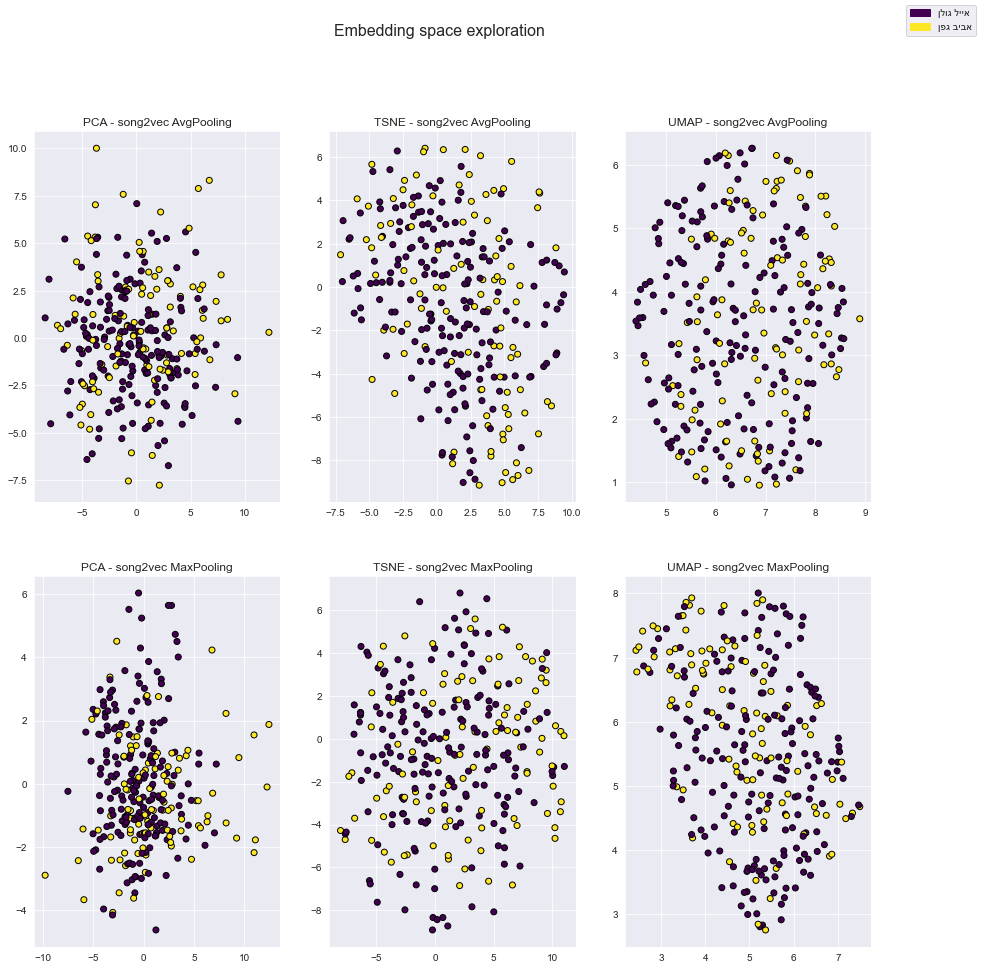

In [50]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from umap import UMAP
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from matplotlib import patches as mpatches

#artists_to_project = ["אייל גולן", "אביב גפן", "יהודית רביץ"]
artists_to_project = ["אייל גולן", "אביב גפן"]
songs_to_project = train_df['artist'].isin(artists_to_project)
labels = [artists_to_project.index(a) for a in train_df['artist'][songs_to_project]]
cmap = plt.cm.get_cmap('viridis', len(artists_to_project))

pca = PCA(n_components=2)
tsne = TSNE(n_components=2)
umap = UMAP(n_components=2)

pca = Pipeline([('scaler', StandardScaler()), ('pca', pca)])
tsne = Pipeline([('scaler', StandardScaler()), ('tsne', tsne)])
umap = Pipeline([('scaler', StandardScaler()), ('umap', umap)])

pca_s2v_mean = pca.fit_transform(train_df['song2vec_mean'][songs_to_project].to_list())
tsne_s2v_mean = tsne.fit_transform(np.array(train_df['song2vec_mean'][songs_to_project].to_list()))
umap_s2v_mean = umap.fit_transform(train_df['song2vec_mean'][songs_to_project].to_list())

pca_s2v_max = pca.fit_transform(train_df['song2vec_max'][songs_to_project].to_list())
tsne_s2v_max = tsne.fit_transform(np.array(train_df['song2vec_max'][songs_to_project].to_list()))
umap_s2v_max = umap.fit_transform(train_df['song2vec_max'][songs_to_project].to_list())

fig, axes = plt.subplots(2, 3, figsize=(15, 15))
fig.suptitle('Embedding space exploration', fontsize=16)
fig.legend(
    handles=[mpatches.Patch(color=cmap(i), label=artists_to_project[i][::-1]) for i in range(len(artists_to_project))],
    loc='upper right')
axes[0, 0].set_title('PCA - song2vec AvgPooling')
axes[0, 0].scatter(pca_s2v_mean[:, 0], pca_s2v_mean[:, 1], c=labels, cmap=cmap, edgecolor='k')
axes[0, 1].set_title('TSNE - song2vec AvgPooling')
axes[0, 1].scatter(tsne_s2v_mean[:, 0], tsne_s2v_mean[:, 1], c=labels, cmap=cmap, edgecolor='k')
axes[0, 2].set_title('UMAP - song2vec AvgPooling')
axes[0, 2].scatter(umap_s2v_mean[:, 0], umap_s2v_mean[:, 1], c=labels, cmap=cmap, edgecolor='k')

axes[1, 0].set_title('PCA - song2vec MaxPooling')
axes[1, 0].scatter(pca_s2v_max[:, 0], pca_s2v_max[:, 1], c=labels, cmap=cmap, edgecolor='k')
axes[1, 1].set_title('TSNE - song2vec MaxPooling')
axes[1, 1].scatter(tsne_s2v_max[:, 0], tsne_s2v_max[:, 1], c=labels, cmap=cmap, edgecolor='k')
axes[1, 2].set_title('UMAP - song2vec MaxPooling')
axes[1, 2].scatter(umap_s2v_max[:, 0], umap_s2v_max[:, 1], c=labels, cmap=cmap, edgecolor='k')

plt.show()

# MultiClass
We will examine the power of the new representation with all different kinds of models - but this time instead of one-vs-all we will try MultiClass - the true task of this project.
We will try different sets of learning algorithms, for each set of algorithms we will find the best model using CV.
We will once again use the f1 score for comparing between the models.

## kNN - revisited

In [28]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedShuffleSplit

X = np.array([np.array(w) for w in train_df['song2vec_mean']])
y = np.array(train_df['artist'])
knn = KNeighborsClassifier(metric='euclidean')
param_grid = {'n_neighbors': np.arange(1, 151, 15)}
cv = StratifiedShuffleSplit(n_splits=3, random_state=42)
knn_gscv = GridSearchCV(knn, param_grid, cv=cv,scoring="f1_micro",error_score="raise",return_train_score=True)
knn_mean = knn_gscv.fit(X, y)
print("kNN Mean Pooling:")
print(f"Best Params: {knn_mean.best_params_}")
print(f"Best f1 score for validation: {100*knn_mean.best_score_}")
print(f"The corresponding train f1 score: {100*knn_mean.cv_results_['mean_train_score'][knn_mean.best_index_]}")

kNN Mean Pooling:
Best Params: {'n_neighbors': 121}
Best f1 score for validation: 9.944311853619729
The corresponding train f1 score: 10.312195984788184


In [29]:
X = np.array([np.array(w) for w in train_df['song2vec_max']])
knn = KNeighborsClassifier(metric='cosine')
param_grid = {'n_neighbors': np.arange(1, 151, 15)}
cv = StratifiedShuffleSplit(n_splits=3, random_state=42)
knn_gscv = GridSearchCV(knn, param_grid, cv=cv,scoring="f1_micro",error_score="raise",return_train_score=True)
knn_max = knn_gscv.fit(X, y)
print("kNN Max Pooling:")
print(f"Best Params: {knn_max.best_params_}")
print(f"Best f1 score for validation: {100*knn_max.best_score_}")
print(f"The corresponding train f1 score: {100*knn_max.cv_results_['mean_train_score'][knn_max.best_index_]}")

kNN Max Pooling:
Best Params: {'n_neighbors': 106}
Best f1 score for validation: 7.875894988066825
The corresponding train f1 score: 9.640045989210224


In [30]:
from sklearn.decomposition import PCA
pca = PCA(n_components=50)
X = np.array([np.array(w) for w in train_df['song2vec_mean']])
X = pca.fit_transform(X)
knn = KNeighborsClassifier(metric='euclidean')
param_grid = {'n_neighbors': np.arange(1, 151, 15)}
cv = StratifiedShuffleSplit(n_splits=3, random_state=42)
knn_gscv = GridSearchCV(knn, param_grid, cv=cv,scoring="f1_micro",error_score="raise",return_train_score=True)
knn_mean_pca = knn_gscv.fit(X, y)
print("kNN Mean Pooling PCA:")
print(f"Best Params: {knn_mean_pca.best_params_}")
print(f"Best f1 score for validation: {100*knn_mean_pca.best_score_}")
print(f"The corresponding train f1 score: {100*knn_mean_pca.cv_results_['mean_train_score'][knn_mean_pca.best_index_]}")

kNN Mean Pooling PCA:
Best Params: {'n_neighbors': 121}
Best f1 score for validation: 9.944311853619729
The corresponding train f1 score: 10.940125585920228


In [31]:
X = np.array([np.array(w) for w in train_df['song2vec_max']])
X = pca.fit_transform(X)
knn = KNeighborsClassifier(metric='cosine')
param_grid = {'n_neighbors': np.arange(1, 151, 15)}
cv = StratifiedShuffleSplit(n_splits=3, random_state=42)
knn_gscv = GridSearchCV(knn, param_grid, cv=cv,scoring="f1_micro",error_score="raise",return_train_score=True)
knn_max_pca = knn_gscv.fit(X, y)
print("kNN Max Pooling PCA:")
print(f"Best Params: {knn_max_pca.best_params_}")
print(f"Best f1 score for validation: {100*knn_max_pca.best_score_}")
print(f"The corresponding train f1 score: {100*knn_max_pca.cv_results_['mean_train_score'][knn_max_pca.best_index_]}")

kNN Max Pooling PCA:
Best Params: {'n_neighbors': 46}
Best f1 score for validation: 9.466984884645983
The corresponding train f1 score: 13.451843990448396


## kNN - analysis

In [53]:
from sklearn.metrics import f1_score, confusion_matrix, classification_report, accuracy_score, \
    precision_score, recall_score

X_test = np.array([np.array(w) for w in val_df['song2vec_mean']])
y_test = val_df['artist']
y_pred = knn_mean.best_estimator_.predict(X_test)
print("The best model was kNN Mean Pooling with validation score of 9.944311853619729")
print('\n------------------ Confusion Matrix -----------------\n')
print(confusion_matrix(y_test, y_pred))

print('\n-------------------- Key Metrics --------------------')
print('\nAccuracy: {:.2f}'.format(accuracy_score(y_test, y_pred)))


print('Micro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='macro')))


print('\n--------------- Classification Report ---------------\n')
print(classification_report(y_test, y_pred))

The best model was kNN Mean Pooling with validation score of 9.944311853619729

------------------ Confusion Matrix -----------------

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 2 0]
 [0 0 0 ... 0 3 1]
 ...
 [0 0 0 ... 0 3 0]
 [0 0 1 ... 0 8 1]
 [0 0 0 ... 0 4 8]]

-------------------- Key Metrics --------------------

Accuracy: 0.09
Micro Precision: 0.09
Micro Recall: 0.09
Micro F1-score: 0.09

Macro Precision: 0.05
Macro Recall: 0.06
Macro F1-score: 0.03


--------------- Classification Report ---------------

                precision    recall  f1-score   support

    אבי טולדנו       0.00      0.00      0.00        21
      אביב גפן       0.00      0.00      0.00        25
     אהוד בנאי       0.00      0.00      0.00        18
     אייל גולן       0.08      0.52      0.14        48
        אילנית       0.00      0.00      0.00        19
אריק איינשטיין       0.24      0.07      0.11        55
   ארקדי דוכין       0.00      0.00      0.00        16
        אתניקס       0.00      0.00      0.

## SVM

In [63]:
from sklearn.svm import SVC
X = np.array([np.array(w) for w in train_df['song2vec_mean']])
C_range = np.logspace(-2, 10, 4)
gamma_range = np.logspace(-9, 3, 4)
param_grid = dict(gamma=gamma_range, C=C_range)
clf = SVC(kernel='rbf')
cv = StratifiedShuffleSplit(n_splits=3, random_state=42)
grid_search = GridSearchCV(clf, param_grid, cv=cv,scoring="f1_micro",error_score="raise",return_train_score=True)
svm_mean = grid_search.fit(X, y)
print("SVM Mean Pooling:")
print(f"Best Params: {svm_mean.best_params_}")
print(f"Best f1 score for validation: {100*svm_mean.best_score_}")
print(f"The corresponding train f1 score: {100*svm_mean.cv_results_['mean_train_score'][svm_mean.best_index_]}")

SVM Mean Pooling:
Best Params: {'C': 100.0, 'gamma': 0.1}
Best f1 score for validation: 13.046937151949086
The corresponding train f1 score: 99.96462368444327


In [66]:
X = np.array([np.array(w) for w in train_df['song2vec_max']])
C_range = np.logspace(-2, 10, 4)
gamma_range = np.logspace(-9, 3, 4)
param_grid = dict(gamma=gamma_range, C=C_range)
clf = SVC(kernel='rbf')
cv = StratifiedShuffleSplit(n_splits=3, random_state=42)
grid_search = GridSearchCV(clf, param_grid, cv=cv,scoring="f1_micro",error_score="raise",return_train_score=True)
svm_max = grid_search.fit(X, y)
print("SVM Max Pooling:")
print(f"Best Params: {svm_max.best_params_}")
print(f"Best f1 score for validation: {100*svm_max.best_score_}")
print(f"The corresponding train f1 score: {100*svm_max.cv_results_['mean_train_score'][svm_max.best_index_]}")

SVM Max Pooling:
Best Params: {'C': 1000000.0, 'gamma': 1e-09}
Best f1 score for validation: 8.671439936356405
The corresponding train f1 score: 10.427169010347571


## SVM - analysis

In [65]:
X_test = np.array([np.array(w) for w in val_df['song2vec_mean']])
y_test = val_df['artist']
y_pred = svm_mean.best_estimator_.predict(X_test)
print("The best model was SVM with RBF kernel with Mean Pooling with validation score of 13.046937151949086")
print('\n------------------ Confusion Matrix -----------------\n')
print(confusion_matrix(y_test, y_pred))

print('\n-------------------- Key Metrics --------------------')
print('\nAccuracy: {:.2f}'.format(accuracy_score(y_test, y_pred)))


print('Micro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='macro')))


print('\n--------------- Classification Report ---------------\n')
print(classification_report(y_test, y_pred))

The best model was SVM with RBF kernel with Mean Pooling with validation score of 13.046937151949086

------------------ Confusion Matrix -----------------

[[ 0  1  0 ...  1  3  0]
 [ 0  1  1 ...  0  1  1]
 [ 0  1  2 ...  0  0  1]
 ...
 [ 0  0  0 ...  0  0  2]
 [ 0  1  0 ...  0  6  1]
 [ 0  0  0 ...  0  0 14]]

-------------------- Key Metrics --------------------

Accuracy: 0.14
Micro Precision: 0.14
Micro Recall: 0.14
Micro F1-score: 0.14

Macro Precision: 0.12
Macro Recall: 0.12
Macro F1-score: 0.12


--------------- Classification Report ---------------

                precision    recall  f1-score   support

    אבי טולדנו       0.00      0.00      0.00        21
      אביב גפן       0.04      0.04      0.04        25
     אהוד בנאי       0.12      0.11      0.11        18
     אייל גולן       0.13      0.17      0.14        48
        אילנית       0.00      0.00      0.00        19
אריק איינשטיין       0.11      0.25      0.16        55
   ארקדי דוכין       0.06      0.06      

## Naive Bayes

In [32]:
from sklearn.naive_bayes import BernoulliNB

clf = BernoulliNB()

X = np.array(train_df['song2vec_mean'].to_list())
y = np.array(train_df['artist'].to_list())

param_grid = {'alpha': np.logspace(-2, 3, 5)}
cv = StratifiedShuffleSplit(n_splits=3, random_state=42)
grid_search = GridSearchCV(clf, param_grid, cv=cv,scoring="f1_micro",error_score="raise",return_train_score=True)
nb_ber_mean = grid_search.fit(X, y)

print("BernoulliNB Mean Pooling:")
print(f"Best Params: {nb_ber_mean.best_params_}")
print(f"Best f1 score for validation: {100*nb_ber_mean.best_score_}")
print(f"The corresponding train f1 score: {100*nb_ber_mean.cv_results_['mean_train_score'][nb_ber_mean.best_index_]}")

BernoulliNB Mean Pooling:
Best Params: {'alpha': 56.23413251903491}
Best f1 score for validation: 9.705648369132856
The corresponding train f1 score: 10.259131511453083


In [33]:
clf = BernoulliNB()

X = np.array(train_df['song2vec_max'].to_list())
y = np.array(train_df['artist'].to_list())

param_grid = {'alpha': np.logspace(-2, 3, 5)}
cv = StratifiedShuffleSplit(n_splits=3, random_state=42)
grid_search = GridSearchCV(clf, param_grid, cv=cv,scoring="f1_micro",error_score="raise",return_train_score=True)
nb_ber_max = grid_search.fit(X, y)

print("BernoulliNB Max Pooling:")
print(f"Best Params: {nb_ber_max.best_params_}")
print(f"Best f1 score for validation: {100*nb_ber_max.best_score_}")
print(f"The corresponding train f1 score: {100*nb_ber_max.cv_results_['mean_train_score'][nb_ber_max.best_index_]}")

BernoulliNB Max Pooling:
Best Params: {'alpha': 0.01}
Best f1 score for validation: 6.682577565632458
The corresponding train f1 score: 6.977978243565933


In [34]:
from sklearn.naive_bayes import GaussianNB

clf = GaussianNB()

X = np.array(train_df['song2vec_mean'].to_list())
y = np.array(train_df['artist'].to_list())

param_grid = {'var_smoothing': np.logspace(-9, 5, 30)}
cv = StratifiedShuffleSplit(n_splits=3, random_state=42)
grid_search = GridSearchCV(clf, param_grid, cv=cv,scoring="f1_micro",error_score="raise",return_train_score=True)
nb_gaus_mean = grid_search.fit(X, y)

print("BernoulliNB Mean Pooling:")
print(f"Best Params: {nb_gaus_mean.best_params_}")
print(f"Best f1 score for validation: {100*nb_gaus_mean.best_score_}")
print(f"The corresponding train f1 score: {100*nb_gaus_mean.cv_results_['mean_train_score'][nb_gaus_mean.best_index_]}")

BernoulliNB Mean Pooling:
Best Params: {'var_smoothing': 0.005736152510448681}
Best f1 score for validation: 8.432776451869533
The corresponding train f1 score: 14.858052533828603


In [35]:
from sklearn.naive_bayes import GaussianNB

clf = GaussianNB()

X = np.array(train_df['song2vec_max'].to_list())
y = np.array(train_df['artist'].to_list())

param_grid = {'var_smoothing': np.logspace(-9, 5, 30)}
cv = StratifiedShuffleSplit(n_splits=3, random_state=42)
grid_search = GridSearchCV(clf, param_grid, cv=cv,scoring="f1_micro",error_score="raise",return_train_score=True)
nb_gaus_max = grid_search.fit(X, y)

print("BernoulliNB Mean Pooling:")
print(f"Best Params: {nb_gaus_max.best_params_}")
print(f"Best f1 score for validation: {100*nb_gaus_max.best_score_}")
print(f"The corresponding train f1 score: {100*nb_gaus_max.cv_results_['mean_train_score'][nb_gaus_max.best_index_]}")

BernoulliNB Mean Pooling:
Best Params: {'var_smoothing': 13.738237958832666}
Best f1 score for validation: 8.83054892601432
The corresponding train f1 score: 9.206686123640223


In [45]:
from sklearn.ensemble import AdaBoostClassifier

X = np.array(train_df['song2vec_mean'].to_list())
y = np.array(train_df['artist'].to_list())

estimator = GaussianNB()
clf = AdaBoostClassifier(base_estimator=estimator)
param_grid = {'n_estimators': [500]}

cv = StratifiedShuffleSplit(n_splits=3, random_state=42)
grid_search = GridSearchCV(clf, param_grid, cv=cv,scoring="f1_micro",error_score="raise",return_train_score=True)
ada_mean = grid_search.fit(X, y)

print("AdaBoost for NB Mean Pooling:")
print(f"Best Params: {ada_mean.best_params_}")
print(f"Best f1 score for validation: {100*ada_mean.best_score_}")
print(f"The corresponding train f1 score: {100*ada_mean.cv_results_['mean_train_score'][ada_mean.best_index_]}")

AdaBoost for NB Mean Pooling:
Best Params: {'n_estimators': 500}
Best f1 score for validation: 10.66030230708035
The corresponding train f1 score: 44.52109312815071


In [46]:
from sklearn.ensemble import AdaBoostClassifier

X = np.array(train_df['song2vec_max'].to_list())
y = np.array(train_df['artist'].to_list())

estimator = GaussianNB()
clf = AdaBoostClassifier(base_estimator=estimator)
param_grid = {'n_estimators': [500]}

cv = StratifiedShuffleSplit(n_splits=3, random_state=42)
grid_search = GridSearchCV(clf, param_grid, cv=cv,scoring="f1_micro",error_score="raise",return_train_score=True)
ada_max = grid_search.fit(X, y)

print("AdaBoost for NB Mean Pooling:")
print(f"Best Params: {ada_max.best_params_}")
print(f"Best f1 score for validation: {100*ada_max.best_score_}")
print(f"The corresponding train f1 score: {100*ada_max.cv_results_['mean_train_score'][ada_max.best_index_]}")

AdaBoost for NB Mean Pooling:
Best Params: {'n_estimators': 500}
Best f1 score for validation: 7.637231503579954
The corresponding train f1 score: 50.38471743167948


## Naive Bayes - analysis

In [54]:
X_test = np.array([np.array(w) for w in val_df['song2vec_mean']])
y_test = val_df['artist']
y_pred = ada_mean.best_estimator_.predict(X_test)
print("The best model was Adaboost-NB Mean Pooling with validation score of 10.66030230708035")
print('\n------------------ Confusion Matrix -----------------\n')
print(confusion_matrix(y_test, y_pred))

print('\n-------------------- Key Metrics --------------------')
print('\nAccuracy: {:.2f}'.format(accuracy_score(y_test, y_pred)))


print('Micro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='macro')))


print('\n--------------- Classification Report ---------------\n')
print(classification_report(y_test, y_pred))

The best model was Adaboost-NB Mean Pooling with validation score of 10.66030230708035

------------------ Confusion Matrix -----------------

[[ 1  0  0 ...  0  2  3]
 [ 1  0  0 ...  1  2  3]
 [ 0  0  0 ...  0  2  1]
 ...
 [ 0  0  0 ...  4  1  2]
 [ 0  2  0 ...  2  5  3]
 [ 0  3  0 ...  0  0 12]]

-------------------- Key Metrics --------------------

Accuracy: 0.10
Micro Precision: 0.10
Micro Recall: 0.10
Micro F1-score: 0.10

Macro Precision: 0.13
Macro Recall: 0.08
Macro F1-score: 0.09


--------------- Classification Report ---------------

                precision    recall  f1-score   support

    אבי טולדנו       0.11      0.05      0.07        21
      אביב גפן       0.00      0.00      0.00        25
     אהוד בנאי       0.00      0.00      0.00        18
     אייל גולן       0.09      0.12      0.11        48
        אילנית       0.00      0.00      0.00        19
אריק איינשטיין       0.12      0.31      0.18        55
   ארקדי דוכין       0.20      0.06      0.10        16

In [55]:
X_test = np.array([np.array(w) for w in val_df['song2vec_mean']])
y_test = val_df['artist']
y_pred = nb_ber_mean.best_estimator_.predict(X_test)
print("This model is BernoulliNB with Mean Pooling with validation score of 9.705648369132856")
print('\n------------------ Confusion Matrix -----------------\n')
print(confusion_matrix(y_test, y_pred))

print('\n-------------------- Key Metrics --------------------')
print('\nAccuracy: {:.2f}'.format(accuracy_score(y_test, y_pred)))


print('Micro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='macro')))


print('\n--------------- Classification Report ---------------\n')
print(classification_report(y_test, y_pred))

This model is BernoulliNB with Mean Pooling with validation score of 9.705648369132856

------------------ Confusion Matrix -----------------

[[ 0  0  0 ...  0  0  2]
 [ 0  0  0 ...  0  0  3]
 [ 0  0  0 ...  0  0  1]
 ...
 [ 0  0  0 ...  0  0  2]
 [ 0  0  0 ...  0  0  5]
 [ 0  0  0 ...  1  0 14]]

-------------------- Key Metrics --------------------

Accuracy: 0.09
Micro Precision: 0.09
Micro Recall: 0.09
Micro F1-score: 0.09

Macro Precision: 0.03
Macro Recall: 0.04
Macro F1-score: 0.02


--------------- Classification Report ---------------

                precision    recall  f1-score   support

    אבי טולדנו       0.00      0.00      0.00        21
      אביב גפן       0.00      0.00      0.00        25
     אהוד בנאי       0.00      0.00      0.00        18
     אייל גולן       0.08      0.42      0.13        48
        אילנית       0.00      0.00      0.00        19
אריק איינשטיין       0.25      0.02      0.03        55
   ארקדי דוכין       0.00      0.00      0.00        16

## lightgbm

In [51]:
from lightgbm import LGBMClassifier

X = np.array(train_df['song2vec_mean'].to_list())

clf = LGBMClassifier(max_depth=2, n_estimators=100, learning_rate=0.1, n_jobs=-1)
param_grid = {}
cv = StratifiedShuffleSplit(n_splits=3, test_size=0.2, random_state=42)
grid = GridSearchCV(clf, param_grid=param_grid, cv=cv, scoring="f1_micro", error_score="raise", return_train_score=True)
gbm_mean = grid.fit(X, y)

print("lightgbm Mean Pooling:")
print(f"Best Params: {gbm_mean.best_params_}")
print(f"Best f1 score for validation: {100*gbm_mean.best_score_}")
print(f"The corresponding train f1 score: {100*gbm_mean.cv_results_['mean_train_score'][gbm_mean.best_index_]}")

lightgbm Mean Pooling:
Best Params: {}
Best f1 score for validation: 10.342084327764518
The corresponding train f1 score: 90.45771144278606


In [52]:
from lightgbm import LGBMClassifier

X = np.array(train_df['song2vec_max'].to_list())

clf = LGBMClassifier(max_depth=2, n_estimators=100, learning_rate=0.1, n_jobs=-1)
param_grid = {}
cv = StratifiedShuffleSplit(n_splits=3, test_size=0.2, random_state=42)
grid = GridSearchCV(clf, param_grid=param_grid, cv=cv, scoring="f1_micro", error_score="raise", return_train_score=True)
gbm_max = grid.fit(X, y)

print("lightgbm Max Pooling:")
print(f"Best Params: {gbm_max.best_params_}")
print(f"Best f1 score for validation: {100*gbm_max.best_score_}")
print(f"The corresponding train f1 score: {100*gbm_max.cv_results_['mean_train_score'][gbm_max.best_index_]}")

lightgbm Max Pooling:
Best Params: {}
Best f1 score for validation: 9.26809864757359
The corresponding train f1 score: 88.10945273631839


## lightgbm - analysis

In [56]:
X_test = np.array([np.array(w) for w in val_df['song2vec_mean']])
y_test = val_df['artist']
y_pred = gbm_mean.best_estimator_.predict(X_test)
print("The best model was lightgbm Mean Pooling with validation score of 10.342084327764518")
print('\n------------------ Confusion Matrix -----------------\n')
print(confusion_matrix(y_test, y_pred))

print('\n-------------------- Key Metrics --------------------')
print('\nAccuracy: {:.2f}'.format(accuracy_score(y_test, y_pred)))


print('Micro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='macro')))


print('\n--------------- Classification Report ---------------\n')
print(classification_report(y_test, y_pred))

The best model was lightgbm Mean Pooling with validation score of 10.342084327764518

------------------ Confusion Matrix -----------------

[[ 0  0  0 ...  1  0  2]
 [ 0  0  0 ...  0  1  2]
 [ 0  0  1 ...  0  0  3]
 ...
 [ 1  0  0 ...  0  0  3]
 [ 1  1  0 ...  0  3  5]
 [ 0  2  0 ...  0  1 15]]

-------------------- Key Metrics --------------------

Accuracy: 0.11
Micro Precision: 0.11
Micro Recall: 0.11
Micro F1-score: 0.11

Macro Precision: 0.09
Macro Recall: 0.09
Macro F1-score: 0.08


--------------- Classification Report ---------------

                precision    recall  f1-score   support

    אבי טולדנו       0.00      0.00      0.00        21
      אביב גפן       0.00      0.00      0.00        25
     אהוד בנאי       0.08      0.06      0.06        18
     אייל גולן       0.10      0.23      0.14        48
        אילנית       0.14      0.05      0.08        19
אריק איינשטיין       0.16      0.22      0.19        55
   ארקדי דוכין       0.14      0.06      0.09        16
 

## The floor is crooked
The journey is not over yet.
Even with song2vec representation, some model were too weak to learn the distribution of the artists while some models over-fitted the training set.
We have two possible hypotheses;
The worst case - the data might be just unwearable - we want to remind you that the initial database is not clean at all - the label that we are trying to classify is "an artist" and not the writer of the song, the correlation might be too weak to learn.
A better case - we are looking at the results from a strict point of view.
Recall, precision and f1 are telling a dry, cold, statistical story;
Different metrics - like looking at the five artists with the highest score?
We will discuss these metrics in the following notebooks.